In [1]:
import pandas as pd
import os
import sys
import csv
import numpy as np
import ast
from spacy.matcher import PhraseMatcher
from spacy import displacy

# Get the parent directory of the current directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to the Python path
sys.path.append(parent_dir)
import myutils
from config import Config

/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.0.1) doesn't match a supported version!
  warnings.warn(


In [2]:
config = Config()
rubrics = myutils.load_rubrics('../' + config.PATH_RUBRIC)

# are long rubrics an issue?
lens = {}
for k,v in rubrics.items():
    lens[k] = len(v['key_element'].tolist())

sorted_lens = sorted(lens.items(), key=lambda x: x[1], reverse=True)
print(sorted_lens)

[('8.1_MM', 18), ('5.12', 16), ('2.4', 16), ('11.1_SDN', 12), ('10.1_TC', 11), ('11.2_SDN', 11), ('6.1_IPP', 10), ('11.3_SDN', 10), ('10.2_TC', 7), ('10.3_TC', 7), ('5.7', 7), ('5', 6), ('2.1_DLL_v1.1', 6), ('12.1_PE', 6), ('6.2_IPP', 6), ('6.3_IPP', 6), ('12.2_PE', 5), ('6.3', 5), ('1.6', 5), ('7', 4), ('1', 4), ('11.4_SDN', 4), ('3', 4), ('4.1_LM_v1.0', 3), ('8.2_MM', 3), ('1.2', 3), ('4.2_LM_v1.0', 3), ('6', 2), ('4', 2), ('4.3_LM', 2), ('2', 2), ('8.3_MM', 2), ('4.13', 2), ('4.3', 2), ('2.3_DLL_v1.1', 2), ('2.2_DLL', 2), ('12.3_PE', 2), ('8', 2), ('5.11', 1)]


In [3]:
# how much similar spans do we predict?

duplicates = []
differences = []
lengths = []
# Open the CSV file and read its contents
with open('../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv', 'r') as csv_file:
    reader = csv.DictReader(csv_file)

    # Iterate over each row in the CSV file
    for row in reader:
        # Extract the justification_cues column as a string
        justification_cues_str = row['justification_cues']
        
        # Convert the string representation of the list of tuples to an actual list
        justification_cues = eval(justification_cues_str)
        
        duplicates.append(len(justification_cues) != len(set(justification_cues)))
        differences.append(len(justification_cues) - len(set(justification_cues)))
        lengths.append(len(justification_cues))
print(len([d for d in duplicates if d==True]))
print(np.average(differences))
        

539
1.853416149068323


In [4]:
converters = {
    'justification_cues': ast.literal_eval,
    'scoring_vectors': ast.literal_eval,
    'justification_cue_spans': ast.literal_eval,
}

In [19]:
# calculate metrics without unseen questions
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

german_ids = [str(i) for i in range(0,9)]

unseen_question_ids = ['2', '5', '1.2', '11.1_SDN', '11.2_SDN', '11.3_SDN', '11.4_SDN']

In [20]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_regression/final_prediction.csv',
              '../results/grading_final_summation_token_classification_regression/final_prediction.csv',
             ] 

In [22]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(float(p['score']))
                y_pred_de.append(float(p['y_pred']))
            else:
                y_true_en.append(float(p['score']))
                y_pred_en.append(float(p['y_pred']))
    print(file_path.split('/')[2])
    print('DE', mean_squared_error(y_true_de, y_pred_de, squared=True))
    print('EN', mean_squared_error(y_true_en, y_pred_en, squared=True))
    y_true_de = [str(i) for i in y_true_de]
    y_pred_de = [str(i) for i in y_pred_de]
    y_true_en = [str(i) for i in y_true_en]
    y_pred_en = [str(i) for i in y_pred_en]
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))

grading_final_decision_tree_span_prediction_regression
DE 0.09605627306273062
EN 0.08725
DE QWK 0.5503978330793973
EN QWK 0.3361328055649021
grading_final_decision_tree_token_classification_regression
DE 0.09300046125461255
EN 0.07554166666666666
DE QWK 0.5912813630748199
EN QWK 0.42839354941227215
grading_final_summation_span_prediction_regression
DE 0.4275830258302583
EN 0.6394583333333334
DE QWK 0.08072731796924748
EN QWK 0.04602767338737712
grading_final_summation_token_classification_regression
DE 0.4280442804428044
EN 0.5360833333333334
DE QWK 0.08054986838256795
EN QWK 0.08520686742268724


In [23]:
file_paths = ['../results/grading_final_decision_tree_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_decision_tree_token_classification_classification/final_prediction.csv',
              '../results/grading_final_summation_span_prediction_classification/final_prediction.csv',
              '../results/grading_final_summation_token_classification_classification/final_prediction.csv',
             ] 

In [24]:
for file_path in file_paths:
    y_true_de, y_pred_de = [], []
    y_true_en, y_pred_en = [], []
    predictions = pd.read_csv(file_path, converters=converters)
    for i, p in predictions.iterrows():
        if p['question_id'] not in unseen_question_ids:
            if p['question_id'] in german_ids:
                y_true_de.append(p['class'])
                y_pred_de.append(p['y_pred'])
            else:
                y_true_en.append(p['class'])
                y_pred_en.append(p['y_pred'])
    print(file_path.split('/')[2])
    print('DE', classification_report(y_true_de, y_pred_de, digits=3))
    print('EN', classification_report(y_true_en, y_pred_en, digits=3))
    print('DE QWK', cohen_kappa_score(y_true_de, y_pred_de, weights='quadratic'))
    print('EN QWK', cohen_kappa_score(y_true_en, y_pred_en, weights='quadratic'))
    print(20*'-')

grading_final_decision_tree_span_prediction_classification
DE                  precision    recall  f1-score   support

        CORRECT      0.642     0.748     0.691       103
      INCORRECT      0.591     0.277     0.377        47
PARTIAL_CORRECT      0.690     0.736     0.712       121

       accuracy                          0.661       271
      macro avg      0.641     0.587     0.593       271
   weighted avg      0.654     0.661     0.646       271

EN                  precision    recall  f1-score   support

        CORRECT      0.774     0.812     0.793       240
      INCORRECT      0.333     0.190     0.242        21
PARTIAL_CORRECT      0.586     0.570     0.578       114

       accuracy                          0.704       375
      macro avg      0.564     0.524     0.538       375
   weighted avg      0.692     0.704     0.697       375

DE QWK 0.4934341735818363
EN QWK 0.406988853318934
--------------------
grading_final_decision_tree_token_classification_classifica

In [25]:
file_path = '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv'
predictions_span = pd.read_csv(file_path, converters=converters)
file_path = '../results/grading_final_decision_tree_token_classification_regression/final_prediction.csv'
predictions_token = pd.read_csv(file_path, converters=converters)

In [26]:
def display_ents(predictions):
    def on_match(matcher, doc, id, matches):
        ents = []
        for m in matches:
            start = m[0]
            end = m[1]
            ents.append({
                'label': 'CUE',
                'span_start': start,
                'span_end': end
            })
        return matches

    def merge_spans(spans):
        sorted_spans = sorted(spans, key=lambda x: x[1])
        merged_spans = []
        for span in sorted_spans:
            if not merged_spans:
                merged_spans.append(span)
            else:
                last_span = merged_spans[-1]
                if last_span[2] >= span[1]:
                    merged_span = (last_span[0], last_span[1], max(last_span[2], span[2]))
                    merged_spans[-1] = merged_span
                else:
                    merged_spans.append(span)
        return merged_spans

    for i, d in predictions.iterrows():
        text = config.nlp(d['text'])
        matcher = PhraseMatcher(config.nlp.vocab)
        spans = []
        for jus_cue in d['justification_cue_spans']:
            for j in jus_cue:
                if len(j):
                    span = config.nlp(j)
                    spans.append(span)
        matcher.add('CUE',spans, on_match=on_match)
        matches = matcher(text)
        matches = merge_spans(matches)
        text.ents = matches
        print(d['question_id'])
        displacy.render(text, style="ent", options={'colors': {'CUE': '#F5F503'}})
        print('True score:', d['score'], 'Predicted score:', d['y_pred'])

In [27]:
display_ents(predictions_token)

8


/Users/felix/opt/anaconda3/envs/thesis3.9/lib/python3.9/site-packages/spacy/displacy/__init__.py:211: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.5 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.75 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.5 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.5 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 0.25 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.5 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.5 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 0.625
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.25 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.25 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.25 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.75 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.625
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.625
5


True score: 0.5 Predicted score: 0.625
5


True score: 1.0 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.0
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.75
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.0
5


True score: 0.5 Predicted score: 0.0
5


True score: 0.75 Predicted score: 1.0
5


True score: 0.25 Predicted score: 0.5
7


True score: 1.0 Predicted score: 0.25
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 0.25
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.0
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.25 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.0 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.625
7


True score: 0.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.75 Predicted score: 0.5
6


True score: 0.75 Predicted score: 0.5
6


True score: 1.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.75 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.875
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.5 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.5 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 0.875
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.75 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.75 Predicted score: 1.0
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.875
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.875
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 1.0
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 1.0
3


True score: 0.5 Predicted score: 0.875
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 1.0 Predicted score: 1.0
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 1.0 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.25
1


True score: 0.75 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
1


True score: 1.0 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 1.0 Predicted score: 0.75
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.0 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.0 Predicted score: 0.25
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.25 Predicted score: 1.0
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.75
1


True score: 0.5 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.75 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 0.875 Predicted score: 0.5
8.2_MM


True score: 0.75 Predicted score: 0.5
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 0.625 Predicted score: 0.75
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 0.375 Predicted score: 0.75
8.2_MM


True score: 0.0 Predicted score: 0.0
8.2_MM


True score: 0.375 Predicted score: 0.75
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 0.5
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 0.5 Predicted score: 1.0
11.1_SDN


True score: 0.75 Predicted score: 1.0
11.1_SDN


True score: 0.5 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 0.5
6.2_IPP


True score: 1.0 Predicted score: 0.25
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 0.5 Predicted score: 0.625
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 0.5 Predicted score: 0.75
6.2_IPP


True score: 0.5 Predicted score: 0.75
6.2_IPP


True score: 0.75 Predicted score: 0.75
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 0.75 Predicted score: 0.625
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 0.5 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 0.5
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.5 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.0 Predicted score: 0.25
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.0 Predicted score: 0.625
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.5
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.625
1.2


True score: 0.75 Predicted score: 0.5
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.5
1.2


True score: 0.75 Predicted score: 0.625
1.2


True score: 0.0 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.0
1.2


True score: 0.25 Predicted score: 0.5
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.5 Predicted score: 1.0
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 0.0 Predicted score: 0.625
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 0.625
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
5.7


True score: 1.0 Predicted score: 0.625
5.7


True score: 0.75 Predicted score: 1.0
5.7


True score: 0.625 Predicted score: 0.625
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.75 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
5.7


True score: 0.75 Predicted score: 0.875
5.7


True score: 0.625 Predicted score: 0.375
5.7


True score: 0.75 Predicted score: 0.375
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
6.3_IPP


True score: 0.5 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 0.75
6.3_IPP


True score: 0.25 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 0.5 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 0.5
6.3_IPP


True score: 0.25 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 0.5 Predicted score: 1.0
6.3_IPP


True score: 0.5 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.75
6.3_IPP


True score: 0.5 Predicted score: 0.5
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 1.0 Predicted score: 0.0
4.3


True score: 1.0 Predicted score: 0.875
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.875
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 0.5 Predicted score: 0.625
11.2_SDN


True score: 0.25 Predicted score: 0.75
11.2_SDN


True score: 0.875 Predicted score: 0.625
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 1.0
11.2_SDN


True score: 1.0 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 0.875
12.1_PE


True score: 0.75 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 0.75 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 0.5 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.75 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 0.875
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 0.75 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 0.875
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.375 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 0.5
10.1_TC


True score: 0.0 Predicted score: 0.25
10.1_TC


True score: 0.0 Predicted score: 0.25
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 0.875 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
4.13


True score: 1.0 Predicted score: 1.0
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 0.75 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 1.0
4.13


True score: 0.0 Predicted score: 0.625
4.13


True score: 0.75 Predicted score: 0.75
4.13


True score: 0.5 Predicted score: 0.625
4.13


True score: 0.5 Predicted score: 0.75
4.13


True score: 0.75 Predicted score: 0.75
4.13


True score: 1.0 Predicted score: 0.75
4.13


True score: 0.75 Predicted score: 0.75
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.875
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.875
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.75
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
6.3


True score: 1.0 Predicted score: 0.75
6.3


True score: 0.625 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 1.0 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.375
6.3


True score: 0.875 Predicted score: 0.5
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.25 Predicted score: 1.0
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.625 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 0.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.5 Predicted score: 0.75
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.75 Predicted score: 0.875
11.3_SDN


True score: 0.75 Predicted score: 0.5
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.875 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 0.0
11.3_SDN


True score: 0.0 Predicted score: 1.0
12.3_PE


True score: 0.75 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 0.0 Predicted score: 0.75
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 0.75 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 0.0 Predicted score: 0.75
10.3_TC


True score: 0.5 Predicted score: 0.75
10.3_TC


True score: 0.75 Predicted score: 0.25
10.3_TC


True score: 1.0 Predicted score: 0.25
10.3_TC


True score: 0.0 Predicted score: 0.75
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.75
2.3_DLL_v1.1


True score: 0.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 0.5 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 0.25 Predicted score: 0.75
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 0.5 Predicted score: 0.375
8.3_MM


True score: 0.5 Predicted score: 0.875
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 0.25 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 0.0 Predicted score: 1.0
8.1_MM


True score: 0.75 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 0.875
8.1_MM


True score: 1.0 Predicted score: 0.5
8.1_MM


True score: 1.0 Predicted score: 0.5
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 0.875 Predicted score: 1.0
8.1_MM


True score: 0.25 Predicted score: 0.75
8.1_MM


True score: 1.0 Predicted score: 0.75
8.1_MM


True score: 0.875 Predicted score: 0.75
8.1_MM


True score: 1.0 Predicted score: 0.875
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 0.5 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 0.5 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 0.625
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
10.2_TC


True score: 0.625 Predicted score: 1.0
10.2_TC


True score: 0.5 Predicted score: 0.5
10.2_TC


True score: 0.75 Predicted score: 0.75
10.2_TC


True score: 1.0 Predicted score: 0.5
10.2_TC


True score: 0.375 Predicted score: 0.25
10.2_TC


True score: 0.75 Predicted score: 0.625
10.2_TC


True score: 0.25 Predicted score: 0.75
10.2_TC


True score: 1.0 Predicted score: 1.0
10.2_TC


True score: 0.75 Predicted score: 0.625
10.2_TC


True score: 0.75 Predicted score: 0.75
10.2_TC


True score: 0.75 Predicted score: 0.75
12.2_PE


True score: 0.0 Predicted score: 0.25
12.2_PE


True score: 1.0 Predicted score: 1.0
12.2_PE


True score: 0.5 Predicted score: 0.25
12.2_PE


True score: 1.0 Predicted score: 0.0
12.2_PE


True score: 0.0 Predicted score: 0.125
12.2_PE


True score: 1.0 Predicted score: 1.0
12.2_PE


True score: 0.0 Predicted score: 0.125
12.2_PE


True score: 1.0 Predicted score: 0.875
12.2_PE


True score: 0.25 Predicted score: 1.0
12.2_PE


True score: 0.0 Predicted score: 0.125
11.4_SDN


True score: 0.75 Predicted score: 0.0
11.4_SDN


True score: 1.0 Predicted score: 1.0
11.4_SDN


True score: 1.0 Predicted score: 0.375
11.4_SDN


True score: 0.75 Predicted score: 0.75
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 1.0 Predicted score: 0.875
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 0.75 Predicted score: 0.75
11.4_SDN


True score: 0.75 Predicted score: 0.875
11.4_SDN


True score: 0.75 Predicted score: 1.0


In [28]:
display_ents(predictions_span)

8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.5 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.75 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.5 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.5 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
8


True score: 1.0 Predicted score: 1.0
8


True score: 0.0 Predicted score: 0.625
8


True score: 0.25 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 0.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 0.625
8


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.5 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.75
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.5 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 0.5
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 1.0 Predicted score: 1.0
4


True score: 0.0 Predicted score: 0.5
4


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 0.625
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.25 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.25 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.25 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.5
5


True score: 0.75 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.75 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.75 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.625
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.625
5


True score: 0.5 Predicted score: 0.625
5


True score: 1.0 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 1.0
5


True score: 1.0 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.0
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.5
5


True score: 0.5 Predicted score: 1.0
5


True score: 0.5 Predicted score: 0.75
5


True score: 0.5 Predicted score: 0.5
5


True score: 1.0 Predicted score: 0.0
5


True score: 0.5 Predicted score: 0.0
5


True score: 0.75 Predicted score: 1.0
5


True score: 0.25 Predicted score: 0.5
7


True score: 1.0 Predicted score: 0.25
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 1.0
7


True score: 1.0 Predicted score: 0.25
7


True score: 0.75 Predicted score: 0.75
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.5 Predicted score: 0.0
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.75
7


True score: 1.0 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.25 Predicted score: 0.75
7


True score: 0.5 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 1.0 Predicted score: 0.625
7


True score: 0.0 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.625
7


True score: 0.0 Predicted score: 0.625
7


True score: 0.5 Predicted score: 0.625
7


True score: 0.75 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.875
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 1.0
7


True score: 0.75 Predicted score: 0.625
7


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 1.0
6


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 0.875
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.75 Predicted score: 0.5
6


True score: 0.75 Predicted score: 0.5
6


True score: 1.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.75 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.25 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.5 Predicted score: 0.5
6


True score: 0.0 Predicted score: 0.5
6


True score: 1.0 Predicted score: 1.0
6


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.875
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.5 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.5 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.5 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.875
2


True score: 0.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 0.875
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.0 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 0.75 Predicted score: 0.5
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
2


True score: 1.0 Predicted score: 1.0
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.75 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.75 Predicted score: 1.0
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.875
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.5 Predicted score: 0.75
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.0 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 0.75
3


True score: 0.5 Predicted score: 0.75
3


True score: 1.0 Predicted score: 0.875
3


True score: 0.0 Predicted score: 0.25
3


True score: 1.0 Predicted score: 1.0
3


True score: 0.25 Predicted score: 0.25
3


True score: 0.75 Predicted score: 0.75
3


True score: 0.25 Predicted score: 0.25
3


True score: 1.0 Predicted score: 1.0
3


True score: 0.5 Predicted score: 0.875
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 1.0 Predicted score: 1.0
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.25
1


True score: 1.0 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.25
1


True score: 0.75 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
1


True score: 1.0 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 1.0 Predicted score: 0.75
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.0 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.0 Predicted score: 0.25
1


True score: 0.25 Predicted score: 0.25
1


True score: 0.25 Predicted score: 1.0
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.25
1


True score: 0.75 Predicted score: 0.75
1


True score: 0.5 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.75 Predicted score: 0.625
1


True score: 0.25 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.5 Predicted score: 0.625
1


True score: 0.75 Predicted score: 1.0
1


True score: 0.5 Predicted score: 0.625
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 0.875 Predicted score: 0.5
8.2_MM


True score: 0.75 Predicted score: 0.5
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 1.0 Predicted score: 0.75
8.2_MM


True score: 0.625 Predicted score: 0.75
8.2_MM


True score: 0.75 Predicted score: 0.75
8.2_MM


True score: 0.375 Predicted score: 0.75
8.2_MM


True score: 0.0 Predicted score: 0.0
8.2_MM


True score: 0.375 Predicted score: 0.75
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 0.5
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 0.5 Predicted score: 1.0
11.1_SDN


True score: 0.75 Predicted score: 1.0
11.1_SDN


True score: 0.5 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 1.0
11.1_SDN


True score: 1.0 Predicted score: 0.5
6.2_IPP


True score: 1.0 Predicted score: 0.25
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 0.5 Predicted score: 0.625
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 0.5 Predicted score: 0.75
6.2_IPP


True score: 0.5 Predicted score: 0.75
6.2_IPP


True score: 0.75 Predicted score: 0.75
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 0.75 Predicted score: 0.625
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 0.5 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 1.0 Predicted score: 0.75
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 1.0
6.2_IPP


True score: 0.75 Predicted score: 1.0
6.2_IPP


True score: 1.0 Predicted score: 0.5
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.5 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.0 Predicted score: 0.25
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 0.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 1.0 Predicted score: 1.0
1.6


True score: 0.0 Predicted score: 0.625
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.5
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.0 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.625
1.2


True score: 0.75 Predicted score: 0.5
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.5
1.2


True score: 0.75 Predicted score: 0.625
1.2


True score: 0.0 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.25 Predicted score: 0.25
1.2


True score: 1.0 Predicted score: 0.0
1.2


True score: 0.25 Predicted score: 0.5
1.2


True score: 1.0 Predicted score: 0.75
1.2


True score: 0.5 Predicted score: 1.0
1.2


True score: 0.25 Predicted score: 0.75
1.2


True score: 1.0 Predicted score: 0.75
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 0.0 Predicted score: 0.625
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 0.625
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.2_LM_v1.0


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
5.7


True score: 1.0 Predicted score: 0.625
5.7


True score: 0.75 Predicted score: 1.0
5.7


True score: 0.625 Predicted score: 0.625
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.75 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
5.7


True score: 0.75 Predicted score: 0.875
5.7


True score: 0.625 Predicted score: 0.375
5.7


True score: 0.75 Predicted score: 0.375
5.7


True score: 1.0 Predicted score: 1.0
5.7


True score: 0.375 Predicted score: 0.375
6.3_IPP


True score: 0.5 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 0.75
6.3_IPP


True score: 0.25 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 0.5 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 1.0 Predicted score: 1.0
6.3_IPP


True score: 1.0 Predicted score: 0.5
6.3_IPP


True score: 0.25 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.875
6.3_IPP


True score: 0.5 Predicted score: 1.0
6.3_IPP


True score: 0.5 Predicted score: 0.5
6.3_IPP


True score: 1.0 Predicted score: 0.75
6.3_IPP


True score: 0.5 Predicted score: 0.5
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 1.0 Predicted score: 0.0
4.3


True score: 1.0 Predicted score: 0.875
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 0.5 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 0.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.625
4.3


True score: 1.0 Predicted score: 0.875
4.3


True score: 1.0 Predicted score: 1.0
4.3


True score: 0.5 Predicted score: 0.625
11.2_SDN


True score: 0.25 Predicted score: 0.75
11.2_SDN


True score: 0.875 Predicted score: 0.625
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 1.0
11.2_SDN


True score: 1.0 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 0.75 Predicted score: 1.0
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 0.75
11.2_SDN


True score: 1.0 Predicted score: 0.875
12.1_PE


True score: 0.75 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 0.75 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 0.5 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 1.0
12.1_PE


True score: 1.0 Predicted score: 0.75
12.1_PE


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.75 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 0.875
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 0.75 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 0.875 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 1.0 Predicted score: 0.875
2.4


True score: 1.0 Predicted score: 1.0
2.4


True score: 0.375 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
6.1_IPP


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 0.5
10.1_TC


True score: 0.0 Predicted score: 0.25
10.1_TC


True score: 0.0 Predicted score: 0.25
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 0.875 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
10.1_TC


True score: 1.0 Predicted score: 1.0
4.13


True score: 1.0 Predicted score: 1.0
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 0.75 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 0.625
4.13


True score: 1.0 Predicted score: 1.0
4.13


True score: 0.0 Predicted score: 0.625
4.13


True score: 0.75 Predicted score: 0.75
4.13


True score: 0.5 Predicted score: 0.625
4.13


True score: 0.5 Predicted score: 0.75
4.13


True score: 0.75 Predicted score: 0.75
4.13


True score: 1.0 Predicted score: 0.75
4.13


True score: 0.75 Predicted score: 0.75
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.875
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.875
4.1_LM_v1.0


True score: 1.0 Predicted score: 0.75
4.1_LM_v1.0


True score: 1.0 Predicted score: 1.0
6.3


True score: 1.0 Predicted score: 0.75
6.3


True score: 0.625 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 1.0 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.375
6.3


True score: 0.875 Predicted score: 0.5
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.25 Predicted score: 1.0
6.3


True score: 0.75 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.625 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
6.3


True score: 0.875 Predicted score: 0.875
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 0.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
2.2_DLL


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.5 Predicted score: 0.75
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.75 Predicted score: 0.875
11.3_SDN


True score: 0.75 Predicted score: 0.5
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 0.875 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 1.0
11.3_SDN


True score: 1.0 Predicted score: 0.0
11.3_SDN


True score: 0.0 Predicted score: 1.0
12.3_PE


True score: 0.75 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 0.0 Predicted score: 0.75
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 1.0 Predicted score: 0.875
12.3_PE


True score: 0.75 Predicted score: 0.875
12.3_PE


True score: 0.75 Predicted score: 0.75
12.3_PE


True score: 1.0 Predicted score: 0.75
12.3_PE


True score: 0.0 Predicted score: 0.75
10.3_TC


True score: 0.5 Predicted score: 0.75
10.3_TC


True score: 0.75 Predicted score: 0.25
10.3_TC


True score: 1.0 Predicted score: 0.25
10.3_TC


True score: 0.0 Predicted score: 0.75
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.5
10.3_TC


True score: 0.75 Predicted score: 0.75
2.3_DLL_v1.1


True score: 0.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 1.0 Predicted score: 0.375
2.3_DLL_v1.1


True score: 0.5 Predicted score: 1.0
2.3_DLL_v1.1


True score: 0.5 Predicted score: 0.375
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 0.25 Predicted score: 0.75
8.3_MM


True score: 0.5 Predicted score: 0.75
8.3_MM


True score: 0.5 Predicted score: 0.375
8.3_MM


True score: 0.5 Predicted score: 0.875
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 1.0 Predicted score: 0.875
8.3_MM


True score: 0.25 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 0.75
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
2.1_DLL_v1.1


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 0.0 Predicted score: 1.0
8.1_MM


True score: 0.75 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 0.875
8.1_MM


True score: 1.0 Predicted score: 0.5
8.1_MM


True score: 1.0 Predicted score: 0.5
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 0.875 Predicted score: 1.0
8.1_MM


True score: 0.25 Predicted score: 0.75
8.1_MM


True score: 1.0 Predicted score: 0.75
8.1_MM


True score: 0.875 Predicted score: 0.75
8.1_MM


True score: 1.0 Predicted score: 0.875
8.1_MM


True score: 1.0 Predicted score: 1.0
8.1_MM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 0.5 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 1.0 Predicted score: 1.0
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
4.3_LM


True score: 1.0 Predicted score: 0.875
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 0.5 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.11


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 0.625
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
5.12


True score: 1.0 Predicted score: 1.0
10.2_TC


True score: 0.625 Predicted score: 1.0
10.2_TC


True score: 0.5 Predicted score: 0.5
10.2_TC


True score: 0.75 Predicted score: 0.75
10.2_TC


True score: 1.0 Predicted score: 0.5
10.2_TC


True score: 0.375 Predicted score: 0.25
10.2_TC


True score: 0.75 Predicted score: 0.625
10.2_TC


True score: 0.25 Predicted score: 0.75
10.2_TC


True score: 1.0 Predicted score: 1.0
10.2_TC


True score: 0.75 Predicted score: 0.625
10.2_TC


True score: 0.75 Predicted score: 0.75
10.2_TC


True score: 0.75 Predicted score: 0.75
12.2_PE


True score: 0.0 Predicted score: 0.25
12.2_PE


True score: 1.0 Predicted score: 1.0
12.2_PE


True score: 0.5 Predicted score: 0.25
12.2_PE


True score: 1.0 Predicted score: 0.0
12.2_PE


True score: 0.0 Predicted score: 0.125
12.2_PE


True score: 1.0 Predicted score: 1.0
12.2_PE


True score: 0.0 Predicted score: 0.125
12.2_PE


True score: 1.0 Predicted score: 0.875
12.2_PE


True score: 0.25 Predicted score: 1.0
12.2_PE


True score: 0.0 Predicted score: 0.125
11.4_SDN


True score: 0.75 Predicted score: 0.0
11.4_SDN


True score: 1.0 Predicted score: 1.0
11.4_SDN


True score: 1.0 Predicted score: 0.375
11.4_SDN


True score: 0.75 Predicted score: 0.75
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 1.0 Predicted score: 0.875
11.4_SDN


True score: 0.75 Predicted score: 1.0
11.4_SDN


True score: 0.75 Predicted score: 0.75
11.4_SDN


True score: 0.75 Predicted score: 0.875
11.4_SDN


True score: 0.75 Predicted score: 1.0


In [29]:
training_data = myutils.load_json('../data/training_dataset.json')

In [30]:
training_data

[{'question_id': '6',
  'tutor_feedback': 'Wichtig ist, dass der Shop geöffnet ist. Die Tankstelle kann auch nachts nur via Nachtschalter geöffnet sein und diese Ergebnisse zählen leider nicht.',
  'label': 'PARTIAL_CORRECT',
  'score': 0.5,
  'lang': 'de',
  'student_answer': 'Täglich zu den Öffnungszeiten',
  'question': 'Frage 6: Zu welcher Tageszeit darf ich den Check durchführen?',
  'reference_answer': 'Es gibt für den Check keine zeitliche Einschränkung (0.5 P), zu welcher Uhrzeit oder an welchem Wochentag der Check durchgeführt werden kann. Die einzige Nebenbedingung ist, dass der Shop geöffnet sein muss (0.5 P), da die Bewertung der Warenpräsentation ein Teil des Jobs ist.'},
 {'question_id': '4.3',
  'tutor_feedback': 'Correct',
  'label': 'CORRECT',
  'score': 0.5,
  'lang': 'en',
  'student_answer': '0.0.0.0 - 0.255.255.255 10.0.0.0 - 10.255.255.255 100.64.0.0 - 100.127.255.255 127.0.0.0 - 127.255.255.255',
  'question': 'Write-down all addresses in Class A networks that ar

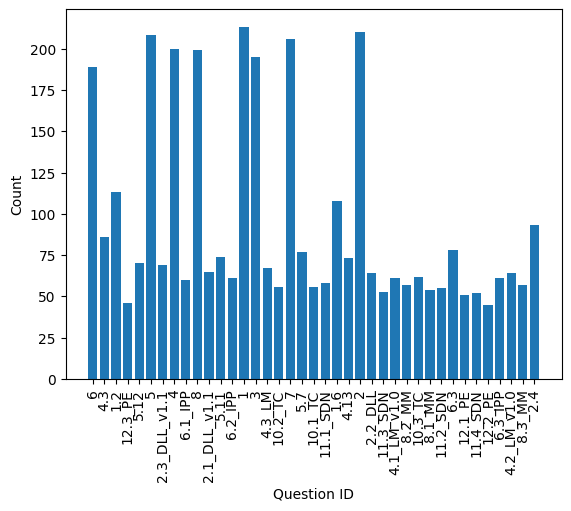

In [31]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
question_counts = Counter(q['question_id'] for q in training_data)

# Plot the histogram
plt.bar(question_counts.keys(), question_counts.values())
plt.xlabel('Question ID')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

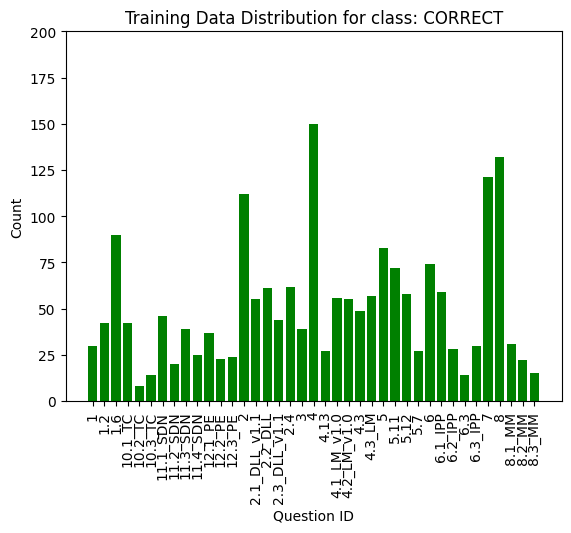

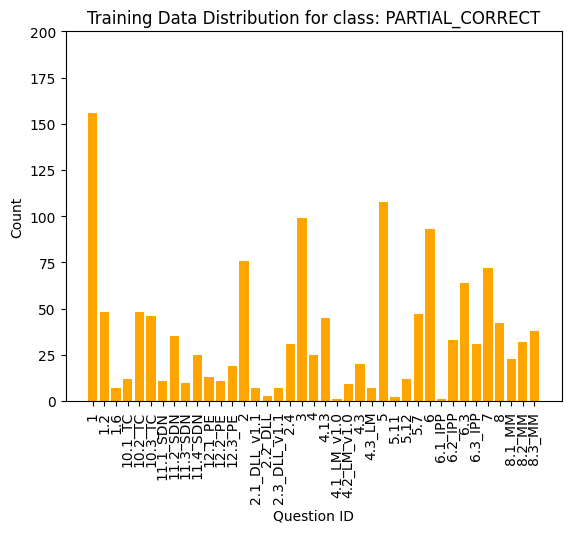

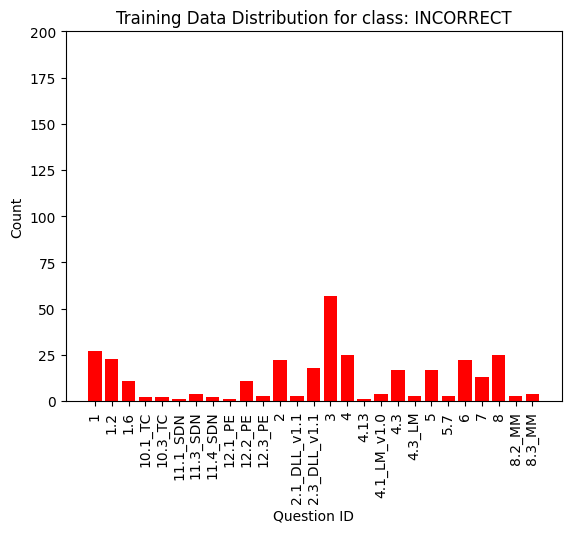

In [32]:
from collections import Counter
import matplotlib.pyplot as plt

# Count the occurrences of each question_id
for l, c in zip(['CORRECT', 'PARTIAL_CORRECT', 'INCORRECT'],  ['green', 'orange', 'red']):
    question_counts = Counter(q['question_id'] for q in training_data if q['label']==l)
    question_counts = sorted(question_counts.items(), key=lambda x: x[0])
    question_counts = {k: v for k, v in question_counts}
    # Plot the histogram
    
    plt.bar(question_counts.keys(), question_counts.values(), color=c)
    plt.title('Training Data Distribution for class: ' + str(l) )
    plt.xlabel('Question ID')
    plt.xticks(rotation=90)
    plt.ylim((0,200))
    plt.ylabel('Count')
    plt.show()

In [33]:
# correlation between classification performance and rubric length

from scipy.stats import pearsonr

x = [4, 3, 4, 11, 7, 7, 12, 11, 10, 4, 6, 5, 2, 2, 6, 2, 2, 16, 3, 2, 3, 2, 2, 2, 2, 6, 1, 16, 7, 2, 10, 6, 5, 6, 4, 2, 18, 3, 2]
y = [0.456, 0.403, 0.303, 0.208, 0.154, 0.222, 0.241, 0.45, 0.25, 0.364, 0.788, 0.775, 0.46, 0.718, 1.0, 0.478, 0.333, 0.622, 0.496, 0.287, 1.0, 0.241, 0.333, 0.237, 0.474, 0.495, 0.489, 0.455, 0.397, 0.43, 1.0, 0.394, 0.442, 0.636, 0.419, 0.307, 0.289, 0.356, 0.222]

corr, pvalue = pearsonr(x, y)
print(f"Pearson correlation coefficient: {corr:.3f}, p-value: {pvalue:.3f}")


Pearson correlation coefficient: 0.011, p-value: 0.949
